In [1]:
library(stringr)
library(ggplot2)
library(ggpubr)
library(dplyr)
library(RColorBrewer)
library(reshape2)
library(phyloseq)
library(caret)
library(vsn)
library(vegan)
library(UpSetR)
library(ade4)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: lattice

Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Welcome to B

# Read phyloseq object

In [2]:
ps <- readRDS(file="/home/zeyang.shen/lab_data/PI/Vitality/RDS/bracken_results_ns38-46+56-57+62+66+94+96_Species_BasedOn_20220511_standard+SMGC+ELSGv2+ns66+T2T.Aug2025.t10.ps.rds")
ps <- subset_taxa(ps, Genus!="Homo")
sample_data.df <- sample_data(ps)
sample_data.df$total_abundance <- rowSums(otu_table(ps))
sample_data(ps) <- sample_data.df
ps <- subset_samples(ps, location!="novaseq6000")
ps <- subset_samples(ps, group!=".")
ps <- subset_samples(ps, !(site_specific %in% c("Ctrl", "PrepCtrl", "(empty)", "N", "ZymoD6306")))
length(unique(sample_data(ps)$family_id))

[1] 429

# Clinical and demographic summary

In [3]:
# Number of participants in each clinical group
baby_data <- subset(as.data.frame(sample_data(ps)), babymom=="B")
baby_data_nonduplicate <- baby_data[!duplicated(baby_data[,c("subject_id")]),]
table(baby_data_nonduplicate$group)
table(baby_data_nonduplicate$group2)


  1   2   3   4 
 95  55 171 108 


 1_no 1_yes  2_no 2_yes 3_yes  4_no 
   22    73    24    31   171   108 

In [4]:
# age at the baseline visit
baby_data_t1 <- subset(as.data.frame(sample_data(ps)), babymom=="B" & visit=="T1")
baby_data_nonduplicate_t1 <- baby_data_t1[!duplicated(baby_data_t1[,c("subject_id")]),]
dim(baby_data_nonduplicate_t1)
bc_age <- as.data.frame(sample_data(baby_data_nonduplicate_t1))$hv_age_mo
quantile(bc_age[!is.na(bc_age)], probs = c(0,0.25,0.5,0.75,1))
for (g in sort(unique(as.data.frame(sample_data(baby_data_nonduplicate_t1))$group))){
    bc_age <- subset(as.data.frame(sample_data(baby_data_nonduplicate_t1)), group==g)$hv_age_mo
    print(g)
    print(quantile(bc_age[!is.na(bc_age)], probs = c(0,0.25,0.5,0.75,1)))
}

[1]  80 158

0%      25%      50%      75%     100% 
1.709402 2.950362 3.418803 3.722880 5.161078

[1] "1"
      0%      25%      50%      75%     100% 
2.202498 3.032544 3.402367 3.583169 3.944773 
[1] "2"
      0%      25%      50%      75%     100% 
2.366864 2.958580 3.122946 3.500986 3.714661 
[1] "3"
      0%      25%      50%      75%     100% 
1.709402 2.827087 3.451677 3.747535 5.161078 
[1] "4"
      0%      25%      50%      75%     100% 
2.038133 3.016108 3.500986 3.763972 5.128205 


In [5]:
# age at the 12-month visit
baby_data_t3 <- subset(as.data.frame(sample_data(ps)), babymom=="B" & visit=="T3")
baby_data_nonduplicate_t3 <- baby_data_t3[!duplicated(baby_data_t3[,c("subject_id")]),]
dim(baby_data_nonduplicate_t3)
yv_age <- as.data.frame(sample_data(baby_data_nonduplicate_t3))$yv_age_mo
quantile(yv_age[!is.na(yv_age)], probs = c(0,0.25,0.5,0.75,1))
for (g in sort(unique(as.data.frame(sample_data(baby_data_nonduplicate_t3))$group))){
    yv_age <- subset(as.data.frame(sample_data(baby_data_nonduplicate_t3)), group==g)$yv_age_mo
    print(g)
    print(quantile(yv_age[!is.na(yv_age)], probs = c(0,0.25,0.5,0.75,1)))
}

[1] 425 158

0%      25%      50%      75%     100% 
12.03156 12.49178 13.08350 13.87245 20.38133

[1] "1"
      0%      25%      50%      75%     100% 
12.06443 12.32742 12.86982 13.64234 17.15976 
[1] "2"
      0%      25%      50%      75%     100% 
12.06443 12.50822 13.14924 13.77383 17.22551 
[1] "3"
      0%      25%      50%      75%     100% 
12.03156 12.52465 13.11637 13.93820 20.38133 
[1] "4"
      0%      25%      50%      75%     100% 
12.06443 12.58218 13.19855 14.11078 18.21170 


In [6]:
# Number of participants with samples collected from affected sites
table(baby_data_nonduplicate_t3$skin_swab_taken_at_eczema_T3, baby_data_nonduplicate_t3$group)

     
        1   2   3   4
  .     1   3   0   0
  no   74  43 126 108
  yes  19   8  43   0

In [7]:
# Number of participants with samples from the baseline visit in each clinical group
table(baby_data_nonduplicate_t1$group2)

# Number of participants with samples from the 12-month visit in each clinical group
table(baby_data_nonduplicate_t3$group2)

# Number of maternal samples in each clinical group
mom_data <- subset(as.data.frame(sample_data(ps)), babymom %in% c("F","M"))
mom_data_nonduplicate <- mom_data[!duplicated(mom_data[,c("subject_id")]),]
table(mom_data_nonduplicate$group2)


 1_no 1_yes  2_no 2_yes 3_yes  4_no 
    5    11     2     5    29    28 


 1_no 1_yes  2_no 2_yes 3_yes  4_no 
   22    72    24    30   169   108 


1_yes  2_no 3_yes  4_no 
   10     1    32    27 

In [8]:
# All SCORAD score quantiles
quantile(subset(baby_data_nonduplicate_t3, group2 %in% c("3_yes", "1_yes", "2_yes") & !is.na(Scorad_Score_T3))$Scorad_Score_T3, 
         probs = c(0,0.25,0.5,0.75,1))

# SCORAD score quantiles for AD+FA
quantile(subset(baby_data_nonduplicate_t3, group2 %in% c("1_yes") & !is.na(Scorad_Score_T3))$Scorad_Score_T3, 
         probs = c(0,0.25,0.5,0.75,1))

# SCORAD score quantiles for AD+FS
quantile(subset(baby_data_nonduplicate_t3, group2 %in% c("2_yes") & !is.na(Scorad_Score_T3))$Scorad_Score_T3, 
         probs = c(0,0.25,0.5,0.75,1))

# SCORAD score quantiles for AD only
quantile(subset(baby_data_nonduplicate_t3, group2 %in% c("3_yes") & !is.na(Scorad_Score_T3))$Scorad_Score_T3, 
         probs = c(0,0.25,0.5,0.75,1))

0%   25%   50%   75%  100% 
 0.00  7.00  7.85 17.35 63.80

0%  25%  50%  75% 100% 
 0.0  7.1 11.6 21.4 63.8

0%  25%  50%  75% 100% 
 3.6  7.3 10.9 17.3 52.6

0%    25%    50%    75%   100% 
 0.000  7.000  7.600 15.025 57.300

In [6]:
# Sex
table(baby_data_nonduplicate$group, baby_data_nonduplicate$cdba_sex)

# Mother country of birth
table(baby_data_nonduplicate$group, baby_data_nonduplicate$mother_cob_d)

# Father country of birth
table(baby_data_nonduplicate$group, baby_data_nonduplicate$father_cob_d)

# Any sibling
table(baby_data_nonduplicate$group, baby_data_nonduplicate$any_sib_d)

# Pet ownership
table(baby_data_nonduplicate$group, baby_data_nonduplicate$ra_pets_yn)

# Any smoker at home
table(baby_data_nonduplicate$group, baby_data_nonduplicate$smoking_home_d)

# Mother any allergy history
table(baby_data_nonduplicate$group, baby_data_nonduplicate$any_allergy_mo_d)


   
    Female Male
  1     37   58
  2     34   21
  3     68  103
  4     57   51

   
      . Africa Australia Europe Far East/East Asia North America Oceania
  1   1      1        62      0                 14             2       2
  2   0      1        39      1                  5             3       3
  3   0      2       133      4                  8             5       6
  4   0      0        91      5                  3             1       5
   
    South America South Asia UK/Britain
  1             2          3          8
  2             1          0          2
  3             3          1          9
  4             0          1          2

   
      .  .m Africa Australia Europe Far East/East Asia Mid East North America
  1   1   1      2        55      2                 12        1             2
  2   1   0      1        38      2                  2        1             1
  3   2   0      7       124      1                  9        2             5
  4   2   0      0        80      1                  2        2             3
   
    Oceania South America South Asia UK/Britain
  1       4             3          2         10
  2       4             0          1          4
  3       8             1          1         11
  4       5             2          1         10

   
      .  no yes
  1   1  60  34
  2   0  35  20
  3   0 109  62
  4   0  56  52

   
    missing/declined/doesn't know No Yes
  1                             1 50  44
  2                             0 26  29
  3                             1 72  98
  4                             0 47  61

   
      . No one is currently smoking at home
  1   1                                  90
  2   0                                  52
  3   1                                 164
  4   0                                 100
   
    Someone is currently smoking at home
  1                                    4
  2                                    3
  3                                    6
  4                                    8

   
     no yes
  1  22  73
  2  20  35
  3  49 122
  4  27  81

# Fig 1a

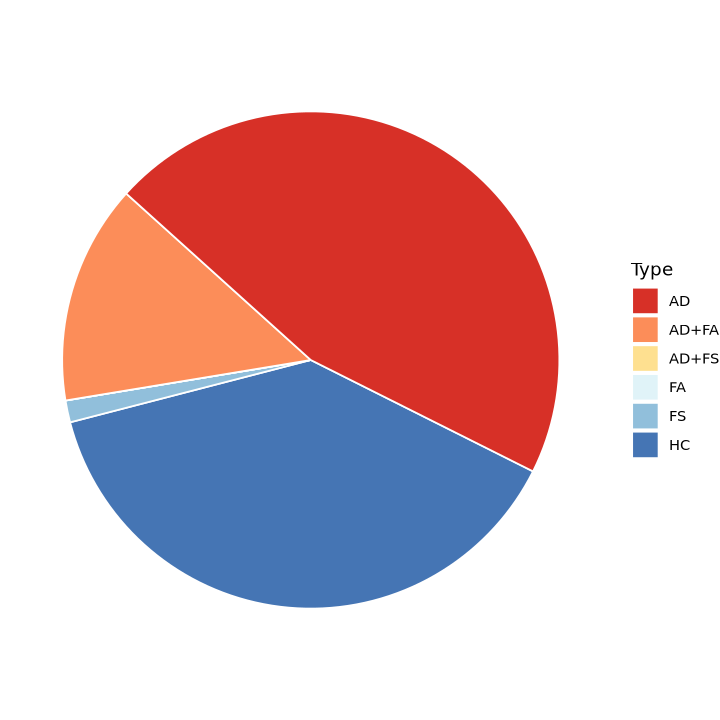

In [27]:
# T1 Ac, Ch
# data <- data.frame(
#     group=c("AD", "AD+FA", "AD+FS", "FA", "FS", "HC"),
#     value=c(29, 11, 5, 5, 2, 28)
# )

# # T3 Ac, Ch
# data <- data.frame(
#     group=c("AD", "AD+FA", "AD+FS", "FA", "FS", "HC"),
#     value=c(169, 72, 30, 22, 24, 108)
# )

# Mom Ac
data <- data.frame(
  group=c("AD", "AD+FA", "AD+FS", "FA", "FS", "HC"),
  value=c(32, 10, 0, 0, 1, 27)
)

data <- data %>% 
  arrange(desc(group)) %>%
  mutate(prop = value / sum(data$value) *100) %>%
  mutate(ypos = cumsum(prop)- 0.5*prop )

options(repr.plot.width = 6, repr.plot.height = 6)
ggplot(data, aes(x="", y=value, fill=group)) +
  geom_bar(stat="identity", width=1, color="white") +
  scale_fill_brewer(palette = "RdYlBu", name = "Type") +
  coord_polar("y", start=90) +
  theme_void()

# Fig 1b

.y.,group1,group2,p,p.adj,p.format,p.signif,method,y.position
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
Scorad_Score_T3,3_yes,2_yes,0.07428192,0.110,0.074,ns,Wilcoxon,75
Scorad_Score_T3,3_yes,1_yes,0.01868067,0.056,0.019,*,Wilcoxon,68
Scorad_Score_T3,2_yes,1_yes,0.97129504,0.970,0.971,ns,Wilcoxon,82


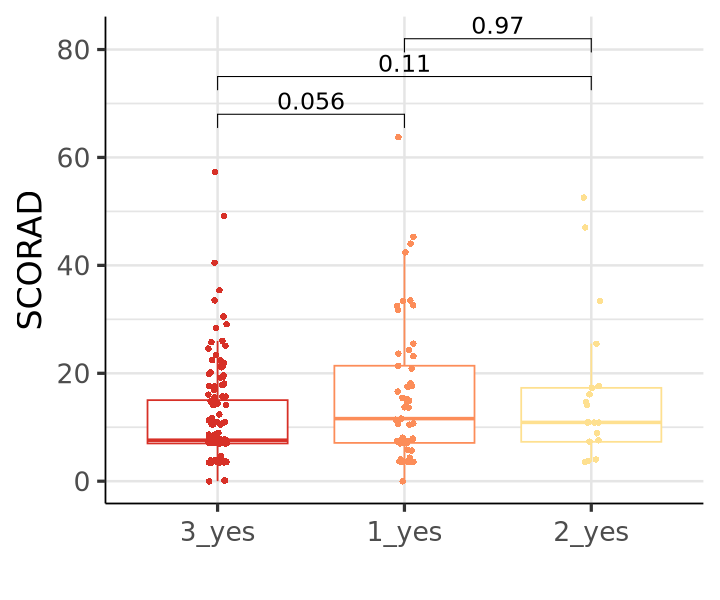

In [83]:
# Number of participants in each clinical group
my_comparisons <- list(c("3_yes", "1_yes"), c("3_yes", "2_yes"), c("1_yes", "2_yes"))
my_cols <- c("#FC8D59","#FEE090","#D73027")
options(repr.plot.width = 6, repr.plot.height = 5)
disp.df <- data.frame(subset(baby_data_nonduplicate_t3, group2 %in% c("3_yes", "1_yes", "2_yes") & !is.na(Scorad_Score_T3)))
pvals <- compare_means(
  Scorad_Score_T3 ~ group2,
  data = disp.df,
  method = "wilcox.test",
  p.adjust.method = "BH"
)
pvals$y.position <- c(75, 68, 82)
pvals <- as.data.frame(pvals)
pvals
p2 <- ggplot(disp.df, aes(x=factor(group2, level=c("3_yes", "1_yes", "2_yes")), y=Scorad_Score_T3, colour=group2)) + 
    geom_boxplot(outlier.shape = NA) + geom_jitter(shape=16, position=position_jitter(0.05)) +
    stat_pvalue_manual(pvals, label="p.adj", size=5) +
    labs(y="SCORAD", x="") +
    theme_classic(base_size=20) +
    theme(axis.text.x = element_text(angle=0, vjust=0.5), 
          legend.position = "none", 
          panel.grid.major.y = element_line(color = "grey90", linewidth = 0.7),
          panel.grid.minor.y = element_line(color = "grey90", linewidth = 0.5),
          panel.grid.major.x = element_line(color = "grey90", linewidth = 0.7),
          axis.line = element_line(color = "black", linewidth = 0.5))+
    scale_color_manual(values = my_cols)
p2
ggsave(p2, width=6, height=5, file="~/figs/AD_scorad.eps", device="eps")

# Metagenome summary

In [11]:
dim(sample_data(ps))
table(sample_data(ps)$babymom_site_visit)

[1] 1078  158


B:Ac:T1 B:Ac:T3 B:Ch:T1 B:Ch:T3 F:Ac:T3 M:Ac:T3 
     80     424      79     425       3      67 

In [12]:
quantile(as.data.frame(sample_data(ps))$total_reads, probs = c(0,0.25,0.5,0.75,1))

0%      25%      50%      75%     100% 
     216  4188227  8910554 16064564 61996069

[1] "Total samples: 1078"
[1] "Samples selected: 1072"
[1] "After filter on reads: 1068"
[1] "Subsampling to reads: 119027"


`set.seed(10)` was used to initialize repeatable random subsampling.

Please record this for your records so others can reproduce.

Try `set.seed(10); .Random.seed` for the full vector

...

1254OTUs were removed because they are no longer 
present in any sample after random subsampling


...



         
          1_no 1_yes 2_no 2_yes 3_yes 4_no
  B:Ac:T1    5    10    2     5    29   28
  B:Ac:T3   21    71   24    30   168  106
  B:Ch:T1    5    11    2     5    28   28
  B:Ch:T3   22    71   24    30   168  105
  F:Ac:T3    0     0    0     0     2    1
  M:Ac:T3    0    10    1     0    30   26

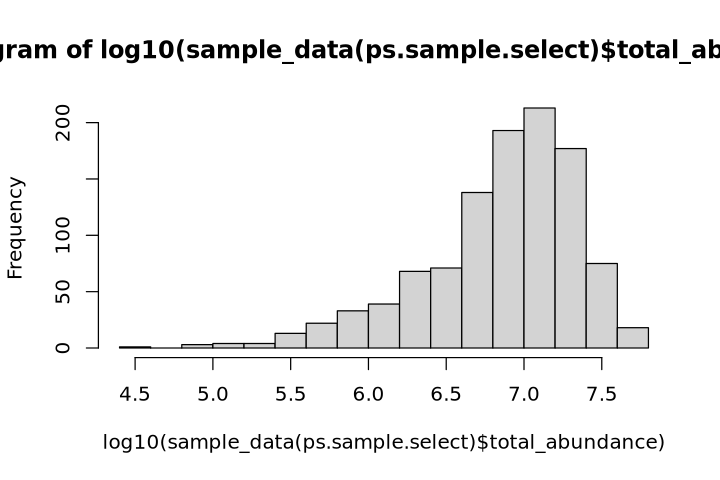

In [85]:
exclude_samples <- c("Met4959", "Met4960", #air control and Ac:T3 likely swapped
                     "Met5191", "Met5192", #control has more reads than samples
                     "Met4929", #similar number of reads as air control
                     "Met5528" #only 8700 total reads
                    )

#1.Select samples
print(paste("Total samples:", nsamples(ps)))
ps.sample.select <- subset_samples(ps, !(Sample %in% exclude_samples))
print(paste("Samples selected:", nsamples(ps.sample.select)))
options(repr.plot.width = 6, repr.plot.height = 4)
hist(log10(sample_data(ps.sample.select)$total_abundance))

##filter sample by total reads
ps.sample.select2 <- subset_samples(ps.sample.select, total_abundance > 100000)
print(paste("After filter on reads:", nsamples(ps.sample.select2)))

##rarefication
print(paste("Subsampling to reads:", min(rowSums(otu_table(ps.sample.select2)))))
ps.rarefy <- rarefy_even_depth(ps.sample.select2, rngseed=10)

table(sample_data(ps.sample.select2)$babymom_site_visit, sample_data(ps.sample.select2)$group2)

In [86]:
table(sample_data(ps.sample.select2)$babymom)


  B   F   M 
998   3  67 

# Fig 1c

In [127]:
variable.table <- data.frame(sample_data(ps.rarefy))
variable.table$babymom_site_visit <- str_replace_all(variable.table$babymom_site_visit, "F:Ac:T3", "M:Ac:T3")
variable.table$ra_pets_yn <- str_replace_all(variable.table$ra_pets_yn, "missing/declined/doesn\'t know", "\\.")
variable.table$ra_livestock_yn <- str_replace_all(variable.table$ra_pets_yn, "missing due to branching", "\\.")
variable.table$father_cob_d <- str_replace_all(variable.table$father_cob_d, ".m", "\\.")
variable.table$any_food_sens <- variable.table$vitality_food_sens=="Food sensitisation" | variable.table$group=="2"

In [17]:
pvals.lst <- list(site=c(), variable=c(), p=c(), stat=c(), type=c())
# single variable
test.vars <- c("any_eczema_ever_d", "vitality_primary", "any_food_sens",
               "cdba_sex", "mother_cob_d", "father_cob_d", "skin_swab_taken_at_eczema_T3", 
               "steroid_T1_d", "steroid_T3_d", 
               "smoking_home_d", "ra_pets_yn", "any_sib_d", "any_allergy_mo_d")
test.num <- 0
for (site in c("B:Ac:T1", "B:Ch:T1", "B:Ac:T3", "B:Ch:T3")) {
    cur.var.table <- subset(variable.table, babymom_site_visit==site)
    test.ps <- subset_samples(ps.rarefy, Sample %in% cur.var.table$Sample)
    feature.table <- data.frame(otu_table(test.ps))
    cur.var.table$shannon <- vegan::diversity(feature.table, index = "shannon", MARGIN = 1, base = exp(1))
    
    set.seed(11)
    print(table(cur.var.table$babymom_site_visit))

    for (variable in test.vars) {
        if (variable == "skin_swab_taken_at_eczema_T3" && site!="B:Ac:T3"){next}
        tbl <- table(cur.var.table[[variable]])
        exclude.ids <- rownames(cur.var.table)[is.na(cur.var.table[[variable]]) | cur.var.table[[variable]]=="." | cur.var.table[[variable]] %in% names(tbl)[tbl<3]]
        test.features <- feature.table[!(rownames(feature.table) %in% exclude.ids),]
        test.variables <- cur.var.table[!(rownames(cur.var.table) %in% exclude.ids),]
        
        # beta diversity
        tryCatch(
            expr = {
                test.res <- adonis2(test.features ~ test.variables[[variable]], 
                                    permutations = 9999, method="bray")
                pval <- test.res$`Pr(>F)`[1]
                r2 <- test.res$R2[1]
                print(paste("beta", variable, pval, r2))
                if (!is.na(pval)){
                    pvals.lst$site <- c(pvals.lst$site, site)
                    pvals.lst$variable <- c(pvals.lst$variable, variable)
                    pvals.lst$p <- c(pvals.lst$p, pval)
                    pvals.lst$stat <- c(pvals.lst$stat, r2)
                    pvals.lst$type <- c(pvals.lst$type, "beta")
                    test.num <- test.num + 1
                    flush.console()   
                }
            },
            error = function(e){
                print(paste("Skipping:", variable))
            }
        )

        # alpha diversity
        tryCatch(
            expr = {
                test.res <- aov(formula(paste0("shannon ~ ", variable)), data=test.variables)
                pval <- summary(test.res)[[1]][["Pr(>F)"]][1]
                fval <- summary(test.res)[[1]][["F value"]][1]
                print(paste("alpha", variable, pval, fval))
                if (!is.na(pval)){
                    pvals.lst$site <- c(pvals.lst$site, site)
                    pvals.lst$variable <- c(pvals.lst$variable, variable)
                    pvals.lst$p <- c(pvals.lst$p, pval)
                    pvals.lst$stat <- c(pvals.lst$stat, fval)
                    pvals.lst$type <- c(pvals.lst$type, "alpha")
                    test.num <- test.num + 1
                    flush.console()   
                }
            },
            error = function(e){
                print(paste("Skipping:", variable))
            }
        )
    }
}


B:Ac:T1 
     79 
[1] "beta any_eczema_ever_d 0.5206 0.0122898675791084"
[1] "alpha any_eczema_ever_d 0.239789667437 1.40345509219279"
[1] "beta vitality_primary 0.0114 0.021531892375513"
[1] "alpha vitality_primary 0.87944326486763 0.0231586550526864"
[1] "beta any_food_sens 0.1602 0.0156294714765682"
[1] "alpha any_food_sens 0.612282016119265 0.258972608715052"
[1] "beta cdba_sex 0.1095 0.016443065203593"
[1] "alpha cdba_sex 0.718731426338001 0.13066705192212"
[1] "beta mother_cob_d 0.0167 0.0556226326720606"
[1] "alpha mother_cob_d 0.429844737204785 0.932406789063939"
[1] "beta father_cob_d 0.1834 0.0760191189936216"
[1] "alpha father_cob_d 0.499778370875021 0.879465341864944"
[1] "Skipping: steroid_T1_d"
[1] "Skipping: steroid_T1_d"
[1] "beta steroid_T3_d 0.3024 0.0147635942904576"
[1] "alpha steroid_T3_d 0.94683232739595 0.00447761318274761"
[1] "beta smoking_home_d 0.3051 0.0141184520849208"
[1] "alpha smoking_home_d 0.95068025659068 0.00385108668216281"
[1] "beta ra_pets_yn 0.7

In [18]:
cur.var.table <- subset(variable.table, babymom=="B")
test.ps <- subset_samples(ps.rarefy, Sample %in% cur.var.table$Sample)
feature.table <- data.frame(otu_table(test.ps))
cur.var.table$shannon <- vegan::diversity(feature.table, index = "shannon", MARGIN = 1, base = exp(1))

for (variable in c("visit", "site_specific")) {
    tbl <- table(cur.var.table[[variable]])
    exclude.ids <- rownames(cur.var.table)[is.na(cur.var.table[[variable]]) | cur.var.table[[variable]]=="." | cur.var.table[[variable]] %in% names(tbl)[tbl<3]]
    test.features <- feature.table[!(rownames(feature.table) %in% exclude.ids),]
    test.variables <- cur.var.table[!(rownames(cur.var.table) %in% exclude.ids),]
    
    # beta diversity
    tryCatch(
        expr = {
            test.res <- adonis2(test.features ~ test.variables[[variable]], 
                                permutations = 9999, method="bray")
            pval <- test.res$`Pr(>F)`[1]
            r2 <- test.res$R2[1]
            print(paste("beta", variable, pval, r2))
            if (!is.na(pval)){
                pvals.lst$site <- c(pvals.lst$site, "All")
                pvals.lst$variable <- c(pvals.lst$variable, variable)
                pvals.lst$p <- c(pvals.lst$p, pval)
                pvals.lst$stat <- c(pvals.lst$stat, r2)
                pvals.lst$type <- c(pvals.lst$type, "beta")
                test.num <- test.num + 1
                flush.console()   
            }
        },
        error = function(e){
            print(paste("Skipping:", variable))
        }
    )

    # alpha diversity
    tryCatch(
        expr = {
            test.res <- aov(formula(paste0("shannon ~ ", variable)), data=test.variables)
            pval <- summary(test.res)[[1]][["Pr(>F)"]][1]
            fval <- summary(test.res)[[1]][["F value"]][1]
            print(paste("alpha", variable, pval, fval))
            if (!is.na(pval)){
                pvals.lst$site <- c(pvals.lst$site, "All")
                pvals.lst$variable <- c(pvals.lst$variable, variable)
                pvals.lst$p <- c(pvals.lst$p, pval)
                pvals.lst$stat <- c(pvals.lst$stat, fval)
                pvals.lst$type <- c(pvals.lst$type, "alpha")
                test.num <- test.num + 1
                flush.console()   
            }
        },
        error = function(e){
            print(paste("Skipping:", variable))
        }
    )
}

[1] "beta visit 1e-04 0.0533563035768407"
[1] "alpha visit 3.21574763095157e-78 420.404700297448"
[1] "beta site_specific 1e-04 0.0738631489672482"
[1] "alpha site_specific 3.80371939109345e-15 63.7893254021814"


In [19]:
pvals.df <- as.data.frame(do.call(cbind, pvals.lst))
pvals.df$p <- as.double(pvals.df$p)
pvals.df$stat <- as.double(pvals.df$stat)
pvals.df <- pvals.df[!is.na(pvals.df$p),]
pvals.df <- pvals.df[order(pvals.df$p),]
pvals.df$q <- p.adjust(pvals.df$p, method="BH")
pvals.df$q <- pmax(pvals.df$q, 1e-3)
head(pvals.df)

,site,variable,p,stat,type,q
,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>
96,All,visit,3.215748e-78,420.40470030,alpha,0.00100000
98,All,site_specific,3.803719e-15,63.78932540,alpha,0.00100000
95,All,visit,1.000000e-04,0.05335630,beta,0.00245000
97,All,site_specific,1.000000e-04,0.07386315,beta,0.00245000
31,B:Ch:T1,mother_cob_d,5.000000e-04,0.08040495,beta,0.00980000
78,B:Ch:T3,cdba_sex,1.184044e-03,10.66133046,alpha,0.01933939


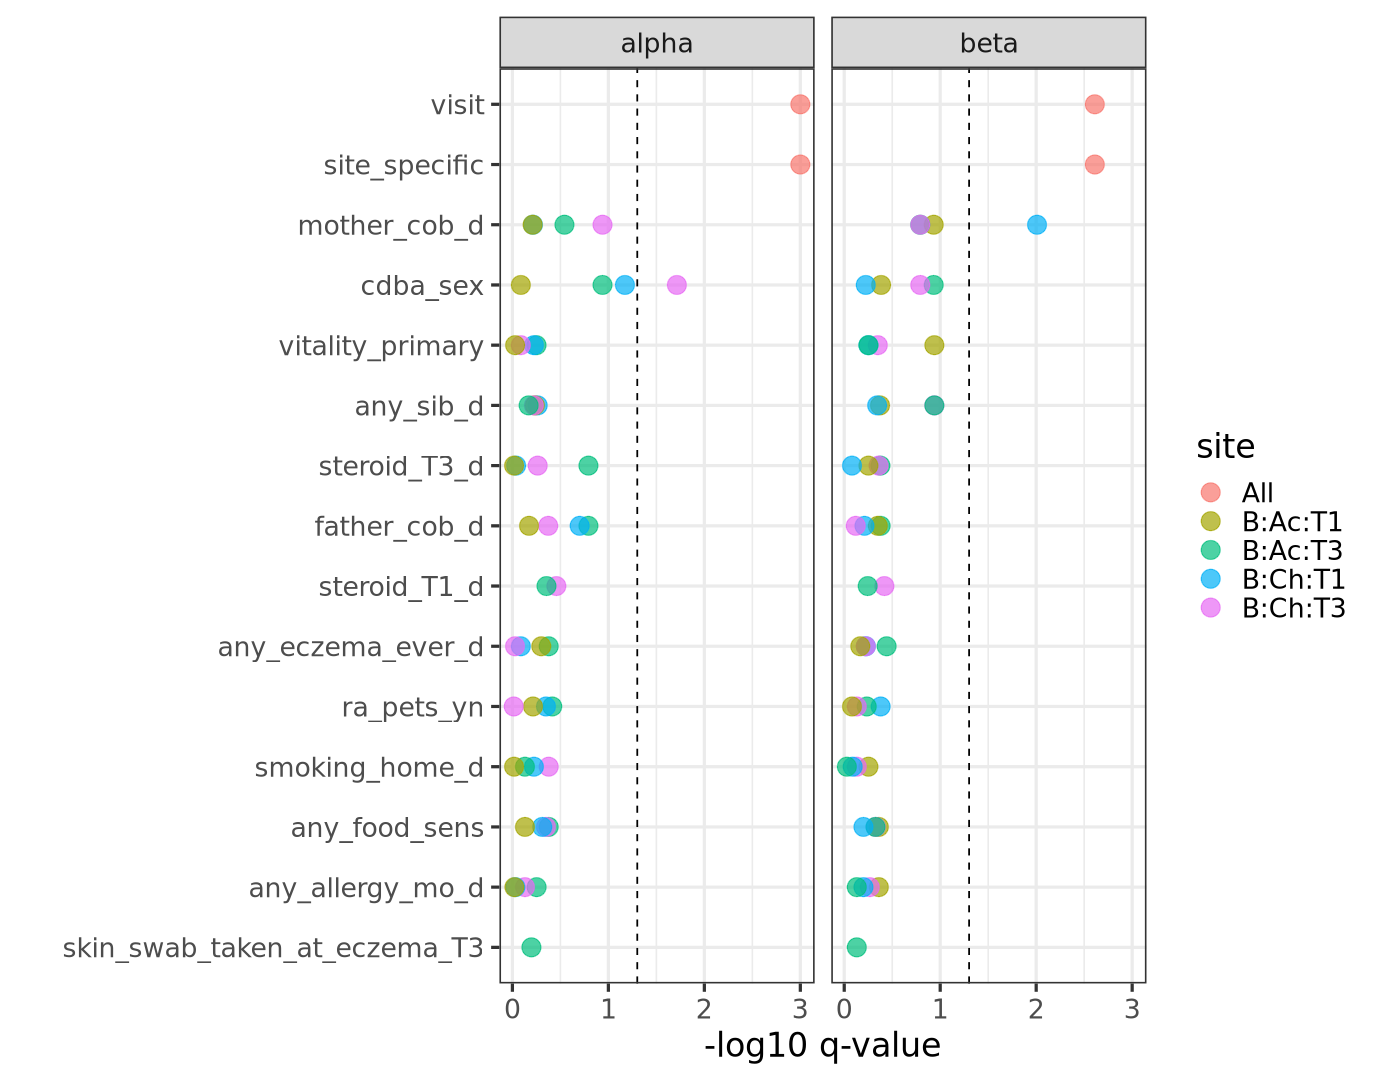

In [25]:
options(repr.plot.width = 11.5, repr.plot.height = 9)
g <- ggplot(pvals.df, aes(x=-log10(q), y=reorder(variable, -q, max), color=site)) +
geom_point(size=5, alpha=0.7) +
geom_vline(xintercept=-log10(0.05), linetype="dashed", color = "black") +
labs(y="", x="-log10 q-value") +
facet_grid(~type, space="free") +
theme_bw(base_size=20)
g
ggsave(g, width=11.5, height=9, file="../figs/AD_alpha_beta_variable_test.png", device="png")

# Fig S1e

In [128]:
cur.var.table <- subset(variable.table, babymom!="M")
test.ps <- subset_samples(ps.rarefy, Sample %in% cur.var.table$Sample)
feature.table <- data.frame(otu_table(test.ps))
cur.var.table$shannon <- vegan::diversity(feature.table, index = "shannon", MARGIN = 1, base = exp(1))

visit,site_specific,.y.,group1,group2,p,p.adj,p.format,p.signif,method,y.position
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
T3,Ac,shannon,Female,Male,0.0159081351,0.0210,0.01591,*,Wilcoxon,6
T3,Ch,shannon,Female,Male,0.0002556157,0.0010,0.00026,***,Wilcoxon,6
T1,Ch,shannon,Female,Male,0.0045527948,0.0091,0.00455,**,Wilcoxon,6
T1,Ac,shannon,Female,Male,0.5951606953,0.6000,0.59516,ns,Wilcoxon,6


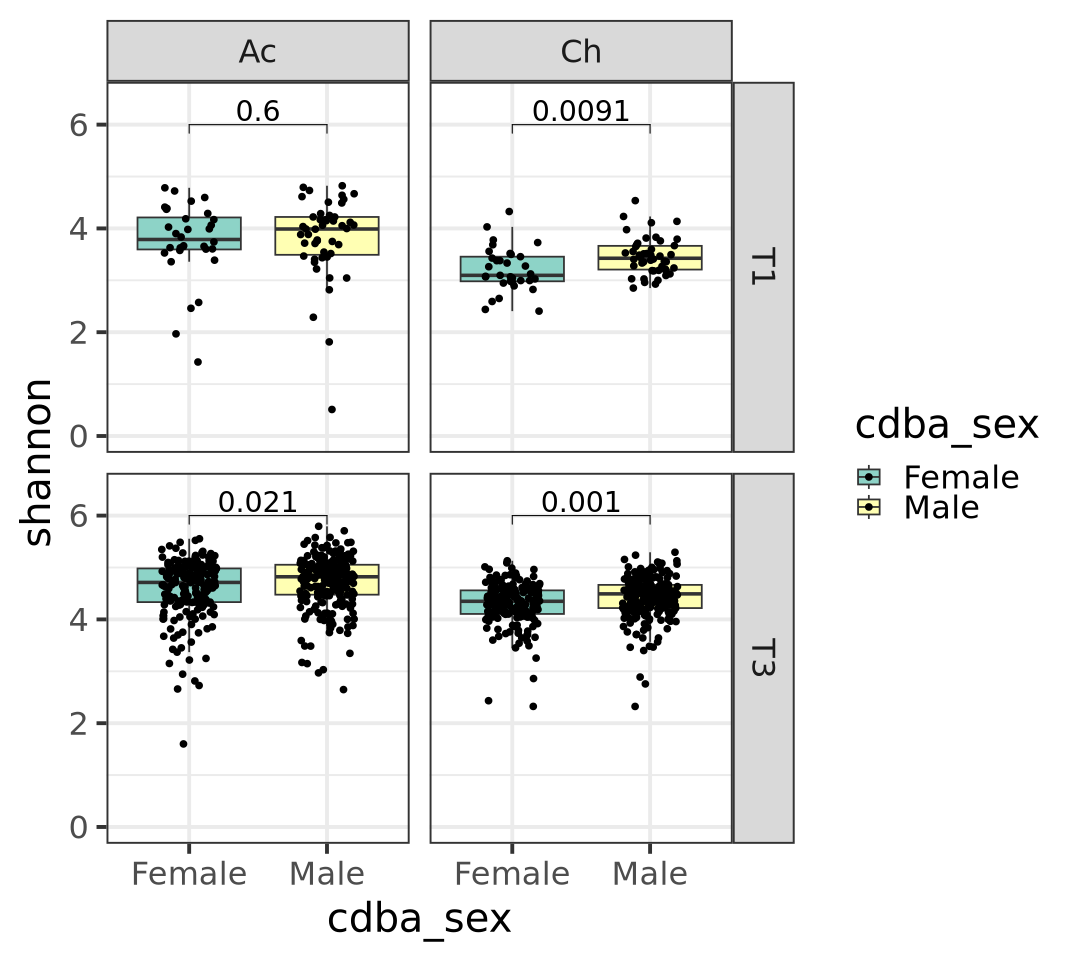

In [143]:
variable <- "cdba_sex"
tbl <- table(cur.var.table[[variable]])
exclude.ids <- rownames(cur.var.table)[is.na(cur.var.table[[variable]]) | cur.var.table[[variable]]=="." | cur.var.table[[variable]] %in% names(tbl)[tbl<3]]
test.features <- feature.table[!(rownames(feature.table) %in% exclude.ids),]
test.variables <- cur.var.table[!(rownames(cur.var.table) %in% exclude.ids),]
pvals <- compare_means(
  shannon ~ cdba_sex,
  data = test.variables,
  method = "wilcox.test",
  p.adjust.method = "BH",
    group.by = c("visit","site_specific")
)
pvals$y.position <- 6
pvals

options(repr.plot.width = 9, repr.plot.height = 8)
g <- ggplot(test.variables, aes_string(x=variable, y="shannon", fill=variable)) +
    geom_boxplot(outlier.shape = NA)+geom_jitter(width = 0.2)+
    stat_pvalue_manual(pvals, label="p.adj", size=6) +
    facet_grid(visit~site_specific, space="free") +
    theme_bw(base_size=24)+
    scale_fill_brewer(palette="Set3")+
    ylim(0, 6.5)
g
ggsave(g, width=9, height=8, file="~/figs/AD_alpha_sex.eps", device="eps")

# Fig 1d

In [144]:
stats_df <- data.frame(sample_data(ps.rarefy))
filtered_otu_table <- otu_table(ps.rarefy)

# calculate alpha diversity
stats_df$richness <- apply(filtered_otu_table,1,function(x) {sum(x>0)})
stats_df$shannon <- vegan::diversity(filtered_otu_table, index = "shannon", MARGIN = 1, base = exp(1))
stats_df$simpson <- vegan::diversity(filtered_otu_table, index = "simpson", MARGIN = 1, base = exp(1))
stats_df$evenness <- stats_df$shannon/log(stats_df$richness)
dim(stats_df)

[1] 1068  162

[1] "4_no"  "2_no"  "3_yes" "2_yes" "1_yes" "1_no"

,visit,site_specific,.y.,group1,group2,p,p.adj,p.format,p.signif,method,y.position
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
5,T3,Ac,shannon,3_yes,4_no,0.28535622,0.61,0.285,ns,Wilcoxon,6.0
9,T3,Ac,shannon,1_yes,4_no,0.18241490,0.61,0.182,ns,Wilcoxon,6.7
12,T3,Ac,shannon,2_yes,4_no,0.11002062,0.55,0.110,ns,Wilcoxon,7.4
14,T3,Ac,shannon,1_no,4_no,0.26571721,0.61,0.266,ns,Wilcoxon,8.1
15,T3,Ac,shannon,2_no,4_no,0.52669065,0.81,0.527,ns,Wilcoxon,8.8
20,T3,Ch,shannon,3_yes,4_no,0.91529838,0.99,0.915,ns,Wilcoxon,6.0
24,T3,Ch,shannon,1_yes,4_no,0.34676578,0.61,0.347,ns,Wilcoxon,6.7
27,T3,Ch,shannon,2_yes,4_no,0.07152698,0.55,0.072,ns,Wilcoxon,7.4
29,T3,Ch,shannon,1_no,4_no,0.30957744,0.61,0.310,ns,Wilcoxon,8.1


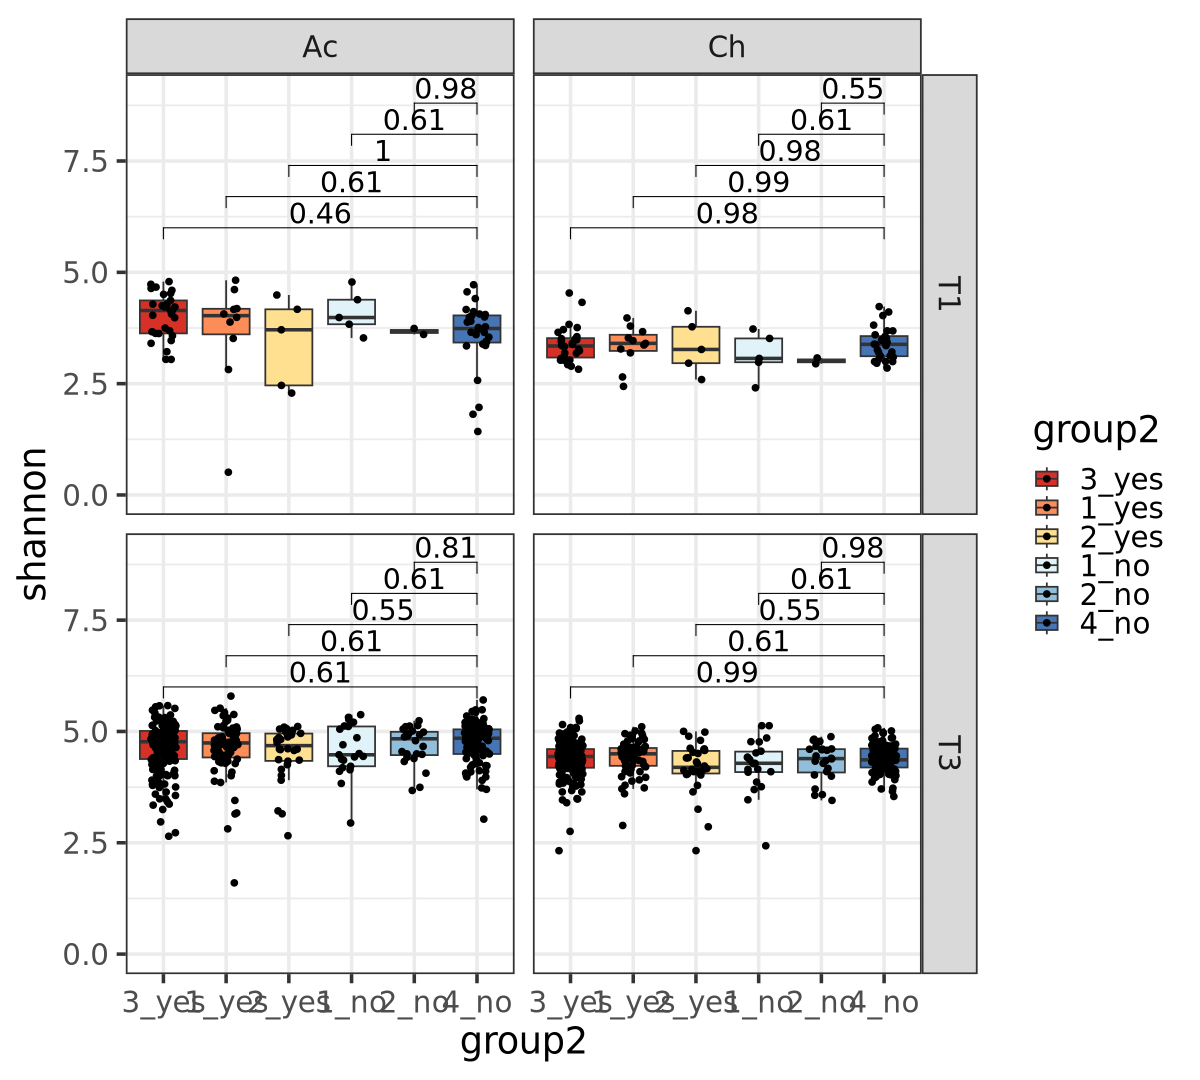

In [153]:
stats_df2 <- subset(stats_df, babymom=="B" & group!=".")
unique(stats_df2$group2)
stats_df2$group2 <- factor(stats_df2$group2, levels = c("3_yes", "1_yes", "2_yes", "1_no", "2_no", "4_no"), ordered = TRUE)

my_comparisons <- list(c("3_yes", "4_no"), c("1_yes", "4_no"), 
                       c("2_yes", "4_no"), c("1_no", "4_no"), 
                       c("2_no", "4_no")) #group2
compare.method = "wilcox.test" #wilcox.test, t.test
compare.metric = "group2"
options(repr.plot.width = 10, repr.plot.height = 9)
symnum.args <- list(cutpoints = c(0, 0.05/20, Inf), symbols = c("*", "ns"))
pvals <- compare_means(
  shannon ~ group2,
  data = stats_df2,
  method = "wilcox.test",
  p.adjust.method = "BH",
    group.by = c("visit","site_specific")
)
pvals <- as.data.frame(pvals)
pvals <- subset(pvals, group2=="4_no" | group1=="4_no")
pvals$p.adj <- signif(p.adjust(pvals$p, method = "BH"),2)
y_map <- c(
  "3_yes" = 6,
  "1_yes" = 6.7,
  "2_yes" = 7.4,
  "1_no"  = 8.1,
  "2_no"  = 8.8
)
pvals$y.position <- y_map[pvals$group1]
pvals
g <- ggplot(stats_df2, aes_string(x=compare.metric, y="shannon", fill=compare.metric)) +
    geom_boxplot(outlier.shape = NA) +
    geom_jitter(width = 0.2) +
    stat_pvalue_manual(pvals, label="p.adj", size=6) +
    scale_x_discrete(guide = guide_axis(angle = 0)) +
    facet_grid(visit~site_specific, space="free") +
    theme_bw(base_size=22)+scale_fill_brewer(palette="RdYlBu")+ylim(0, 9)
g
ggsave(g, width=10, height=9, file="~/figs/AD_alpha_disease.eps", device="eps")

# Fig S1f


 1_yes_no 1_yes_yes  2_yes_no 2_yes_yes  3_yes_no 3_yes_yes 
       52        18        21         8       125        43 

,visit,site_specific,.y.,group1,group2,p,p.adj,p.format,p.signif,method,y.position
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
1,T3,Ac,shannon,3_yes_yes,3_yes_no,0.56087799,0.80,0.561,ns,Wilcoxon,6.5
10,T3,Ac,shannon,1_yes_yes,1_yes_no,0.07949665,0.66,0.079,ns,Wilcoxon,6.5
15,T3,Ac,shannon,2_yes_yes,2_yes_no,0.37421569,0.70,0.374,ns,Wilcoxon,6.5


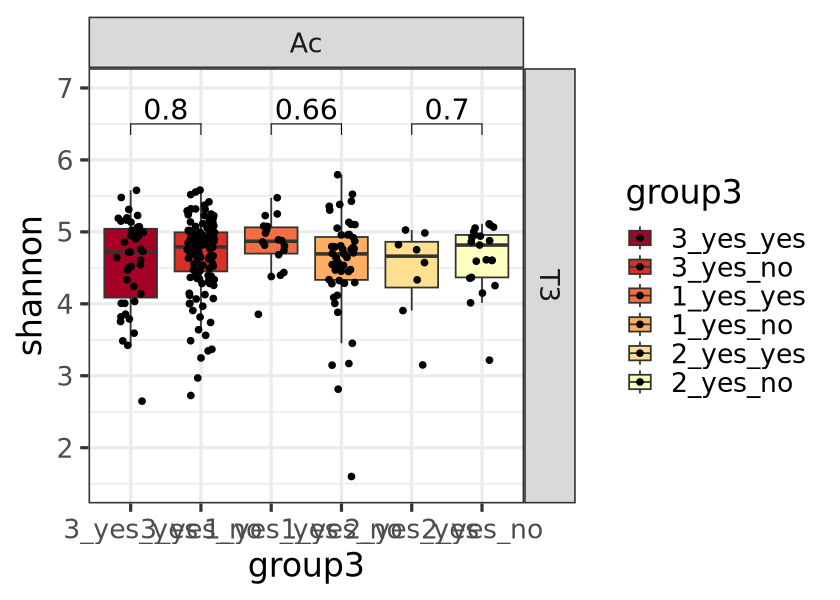

In [125]:
select.groups <- c("3_yes_yes", "3_yes_no", "1_yes_yes", "1_yes_no", "2_yes_yes", "2_yes_no")
stats_df2 <- subset(stats_df, babymom_site_visit=="B:Ac:T3" & group3 %in% select.groups)
table(stats_df2$group3)
stats_df2$group3 <- factor(stats_df2$group3, levels = select.groups, ordered = TRUE)

my_comparisons <- list(c("3_yes_no", "3_yes_yes"), c("1_yes_no", "1_yes_yes"), c("2_yes_no", "2_yes_yes")) #group3
compare.method = "wilcox.test" #wilcox.test, t.test
compare.metric = "group3"
options(repr.plot.width = 7, repr.plot.height = 5)
symnum.args <- list(cutpoints = c(0, 0.05/20, Inf), symbols = c("*", "ns"))
my_cols <- brewer.pal(11, "RdYlBu")[1:6]
pvals <- compare_means(
  shannon ~ group3,
  data = stats_df2,
  method = "wilcox.test",
  p.adjust.method = "BH",
    group.by = c("visit","site_specific")
)
pvals <- as.data.frame(pvals)
pvals <- subset(pvals, (group1=="3_yes_yes"&group2=="3_yes_no")|(group1=="1_yes_yes"&group2=="1_yes_no")|(group1=="2_yes_yes"&group2=="2_yes_no"))
pvals$y.position <- c(6.5,6.5,6.5)
pvals
g <- ggplot(stats_df2, aes_string(x=compare.metric, y="shannon", fill=compare.metric)) +
    geom_boxplot(outlier.shape = NA) +
    geom_jitter(width = 0.2) +
    stat_pvalue_manual(pvals, label="p.adj", size=6) +
    scale_x_discrete(guide = guide_axis(angle = 0)) +
    facet_grid(visit~site_specific, space="free") +
    theme_bw(base_size=20)+
    scale_fill_manual(values = my_cols) +
    scale_color_manual(values = my_cols)+
    ylim(1.5, 7)
g
ggsave(g, width=7, height=5, file="~/figs/AD_alpha_affectedStatus.eps", device="eps")

# Fig S1d

In [31]:
#2.Select taxa
ps.taxa.select <- subset_taxa(subset_samples(ps.rarefy, babymom_site_visit=="B:Ch:T1"))
print(paste("Taxa selected:", ntaxa(ps.taxa.select)))

#filter taxa by prevalence
prevalenceThreshold = 0.01 * nsamples(ps.taxa.select)
print(paste('Prevalence threshold:', prevalenceThreshold))
max.reads <- max(rowSums(otu_table(ps.sample.select)))
prevdf = apply(X = otu_table(ps.taxa.select), 
               MARGIN = ifelse(taxa_are_rows(ps.taxa.select), yes = 1, no = 2),
               FUN = function(x){sum(x > 10)})
prevdf = data.frame(Prevalence = prevdf, TotalAbundance = taxa_sums(ps.taxa.select), tax_table(ps.taxa.select))
keepTaxa_prev = rownames(prevdf)[(prevdf$Prevalence >= prevalenceThreshold)]
ps.taxa.select <- prune_taxa(keepTaxa_prev, ps.taxa.select)
print(paste("After filter on prevalance:", ntaxa(ps.taxa.select)))

#filter taxa by abundance
min.abund <- max.reads/1000
keepTaxa_abund <- taxa_names(ps.taxa.select)[apply(otu_table(ps.taxa.select),2,max) > min.abund]
# ps.taxa.select <- prune_taxa(keepTaxa_abund, ps.taxa.select)
print(paste("After filter on abundance at", min.abund, ":", ntaxa(ps.taxa.select)))

[1] "Taxa selected: 8374"
[1] "Prevalence threshold: 0.79"
[1] "After filter on prevalance: 1548"
[1] "After filter on abundance at 61749.378 : 1548"


In [32]:
ps.transform <- transform_sample_counts(subset_samples(ps.taxa.select, mother_cob_d %in% c("Australia","Europe","Far East/East Asia","South Asia")), function(x) {log(x+1)})
sample_data.df <- sample_data(ps.transform)
sample_data.df$babymom_site_visit <- str_replace_all(sample_data.df$babymom_site_visit, "F", "M")
# sample_data.df$mother_cob_d <- str_replace_all(str_replace_all(sample_data.df$mother_cob_d, "Far East/East ", ""), "South ", "")
sample_data(ps.transform) <- sample_data.df

#ordination methods: DCA, CCA, NMDS, PCoA
GP.ord <- ordinate(ps.transform, "PCoA", "bray")
# proportion of variance explained
sapply(GP.ord$values$Eigenvalues[1:5], function(x) {x / sum(GP.ord$values$Eigenvalues)})     

[1] 0.12728625 0.09800787 0.05255886 0.04072492 0.03796943

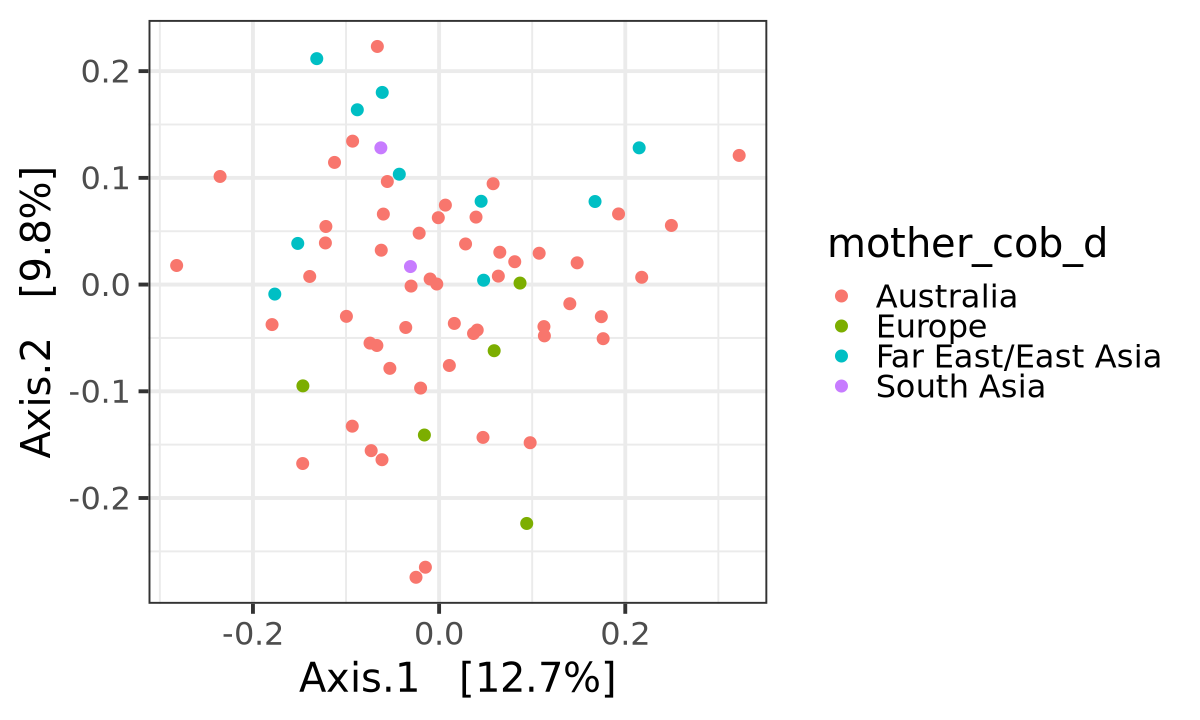

In [35]:
options(repr.plot.width = 10, repr.plot.height = 6)
g <- plot_ordination(ps.transform, GP.ord, type="samples",
                      color="mother_cob_d", axes=c(1,2)) +
    geom_point(size=3) +
    theme_bw(base_size=24)
g
ggsave(g, width=10, height=6, file="../figs/AD_beta_MotherCOB.eps", device="eps")